In [82]:
import scipy         
import datetime
from scipy.linalg import expm,det, logm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [83]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=2
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [84]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [85]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [86]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [87]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [88]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [89]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [90]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [91]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [92]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [93]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [94]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


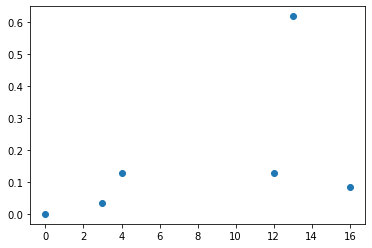

In [95]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [96]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [97]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full.toarray()


In [98]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full.toarray()




In [99]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [109]:
def R(i,theta):
    
    if i%9 == 0:
        return(exp_gate(0,theta))

    if i%9 == 1:
        return(exp_gate(1,theta))

    if i%9 == 2:
        return(exp_gate(2,theta))

    
    if i%9 == 3:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%9 == 4:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%9 == 5:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%9 == 6:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%9 == 7:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%9 == 8:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i,theta):
    
    if i%9 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,-theta))

    if i%9 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,-theta))
    
    if i%9 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,-theta))
     
    if i%9 == 3:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%9 == 4:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%9 == 5:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%9 == 6:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%9 == 7:
        return(-1j*sigma_r(0,2,0).toarray())
    

    if i%9 == 8:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [110]:
coeff = 9
stepp = 600
t_final = 2

In [111]:
matr = full_ham_matrix.toarray()
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

In [112]:
def rhs(t,theta):
    
    print(datetime.datetime.now())
    for k in range(coeff*N):
        B[k] = R(k,theta[k])
        
    psi_b = psi_0
    for k in range(coeff*N):
        psi_b = B[coeff*N-1-k]@psi_b
        
    psi_conj_b = np.conj(psi_b)

    print("start",datetime.datetime.now())
    
    for k in range(coeff*N):
        B[k] = S(k,theta[k])@R(k,theta[k])
        psi_d[k] = psi_0
        for i in range(coeff*N):
            psi_d[k] = B[coeff*N-1-i]@psi_d[k]
        B[k] = R(k,theta[k])
        
    print("stop_reduce",datetime.datetime.now())
    
    psi_conj_d = np.conj(psi_d)
    


    
    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)


    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [113]:
time_domain = np.linspace(0, t_final, stepp)


In [114]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [115]:
#start_point = 0.001*np.ones(coeff*N)
expt_value = []
energyy = []

for kkk in range(1):
    Y = []
    start_point = np.random.rand(coeff*N)
    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])

        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))
        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-10 18:51:47.497142
start 2022-08-10 18:51:47.577869


/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


stop_reduce 2022-08-10 18:51:47.820877
2022-08-10 18:51:47.821631
0
2022-08-10 18:51:47.821679
start 2022-08-10 18:51:47.904214
stop_reduce 2022-08-10 18:51:48.146461
2022-08-10 18:51:48.147190
0.0016666666666666668
2022-08-10 18:51:48.147314
start 2022-08-10 18:51:48.230275
stop_reduce 2022-08-10 18:51:48.473773
2022-08-10 18:51:48.474855
0.0016666666666666668
2022-08-10 18:51:48.474926
start 2022-08-10 18:51:48.567379
stop_reduce 2022-08-10 18:51:48.815017
2022-08-10 18:51:48.815748
0.0033333333333333335
2022-08-10 18:51:48.815804
start 2022-08-10 18:51:48.897995
stop_reduce 2022-08-10 18:51:49.138834
2022-08-10 18:51:49.139580
0.0033333333333333335
2022-08-10 18:51:49.139776
start 2022-08-10 18:51:49.221978
stop_reduce 2022-08-10 18:51:49.462181
2022-08-10 18:51:49.462921
0.005
2022-08-10 18:51:49.462970
start 2022-08-10 18:51:49.545178
stop_reduce 2022-08-10 18:51:49.789859
2022-08-10 18:51:49.790604
0.005
2022-08-10 18:51:49.790730
start 2022-08-10 18:51:49.873143
stop_reduce 2022

stop_reduce 2022-08-10 18:52:07.051210
2022-08-10 18:52:07.051934
0.04833333333333333
2022-08-10 18:52:07.052124
start 2022-08-10 18:52:07.134330
stop_reduce 2022-08-10 18:52:07.374476
2022-08-10 18:52:07.375237
0.05
2022-08-10 18:52:07.375292
start 2022-08-10 18:52:07.457917
stop_reduce 2022-08-10 18:52:07.699897
2022-08-10 18:52:07.700627
0.05
2022-08-10 18:52:07.700679
start 2022-08-10 18:52:07.783046
stop_reduce 2022-08-10 18:52:08.022499
2022-08-10 18:52:08.023241
0.051666666666666666
2022-08-10 18:52:08.023290
start 2022-08-10 18:52:08.105479
stop_reduce 2022-08-10 18:52:08.347130
2022-08-10 18:52:08.347874
0.051666666666666666
2022-08-10 18:52:08.348070
start 2022-08-10 18:52:08.431981
stop_reduce 2022-08-10 18:52:08.673513
2022-08-10 18:52:08.674224
0.05333333333333334
2022-08-10 18:52:08.674276
start 2022-08-10 18:52:08.756912
stop_reduce 2022-08-10 18:52:08.998040
2022-08-10 18:52:08.998756
0.05333333333333334
2022-08-10 18:52:08.998811
start 2022-08-10 18:52:09.081266
stop_r

stop_reduce 2022-08-10 18:52:25.606835
2022-08-10 18:52:25.607504
0.09666666666666661
2022-08-10 18:52:25.607557
start 2022-08-10 18:52:25.689516
stop_reduce 2022-08-10 18:52:25.935559
2022-08-10 18:52:25.936385
0.09666666666666661
2022-08-10 18:52:25.936537
start 2022-08-10 18:52:26.018423
stop_reduce 2022-08-10 18:52:26.257477
2022-08-10 18:52:26.258167
0.09833333333333327
2022-08-10 18:52:26.258215
start 2022-08-10 18:52:26.340301
stop_reduce 2022-08-10 18:52:26.580432
2022-08-10 18:52:26.581152
0.09833333333333327
2022-08-10 18:52:26.581340
start 2022-08-10 18:52:26.663148
stop_reduce 2022-08-10 18:52:26.905845
2022-08-10 18:52:26.906553
0.09999999999999994
2022-08-10 18:52:26.906610
start 2022-08-10 18:52:26.990127
stop_reduce 2022-08-10 18:52:27.230084
2022-08-10 18:52:27.230805
0.09999999999999994
2022-08-10 18:52:27.230932
start 2022-08-10 18:52:27.313056
stop_reduce 2022-08-10 18:52:27.552719
2022-08-10 18:52:27.553452
0.1016666666666666
2022-08-10 18:52:27.553503
start 2022-0

stop_reduce 2022-08-10 18:52:44.675000
2022-08-10 18:52:44.675737
0.1433333333333332
2022-08-10 18:52:44.675921
start 2022-08-10 18:52:44.759607
stop_reduce 2022-08-10 18:52:45.021678
2022-08-10 18:52:45.022621
0.14499999999999988
2022-08-10 18:52:45.022680
start 2022-08-10 18:52:45.114456
stop_reduce 2022-08-10 18:52:45.397674
2022-08-10 18:52:45.398213
0.14499999999999988
2022-08-10 18:52:45.398273
start 2022-08-10 18:52:45.534642
stop_reduce 2022-08-10 18:52:45.822409
2022-08-10 18:52:45.823165
0.14666666666666653
2022-08-10 18:52:45.823224
start 2022-08-10 18:52:45.910487
stop_reduce 2022-08-10 18:52:46.172988
2022-08-10 18:52:46.173593
0.14666666666666653
2022-08-10 18:52:46.173658
start 2022-08-10 18:52:46.265929
stop_reduce 2022-08-10 18:52:46.528130
2022-08-10 18:52:46.528810
0.1483333333333332
2022-08-10 18:52:46.528879
start 2022-08-10 18:52:46.612169
stop_reduce 2022-08-10 18:52:46.882686
2022-08-10 18:52:46.883446
0.1483333333333332
2022-08-10 18:52:46.883653
start 2022-08-

stop_reduce 2022-08-10 18:53:04.261378
2022-08-10 18:53:04.261988
0.19166666666666646
2022-08-10 18:53:04.262053
start 2022-08-10 18:53:04.349586
stop_reduce 2022-08-10 18:53:04.590111
2022-08-10 18:53:04.590761
0.19166666666666646
2022-08-10 18:53:04.590829
start 2022-08-10 18:53:04.678997
stop_reduce 2022-08-10 18:53:04.921204
2022-08-10 18:53:04.921826
0.1933333333333331
2022-08-10 18:53:04.921899
start 2022-08-10 18:53:05.004534
stop_reduce 2022-08-10 18:53:05.251993
2022-08-10 18:53:05.252738
0.1933333333333331
2022-08-10 18:53:05.252792
start 2022-08-10 18:53:05.336394
stop_reduce 2022-08-10 18:53:05.584354
2022-08-10 18:53:05.585165
0.19499999999999978
2022-08-10 18:53:05.585218
start 2022-08-10 18:53:05.668469
stop_reduce 2022-08-10 18:53:05.912435
2022-08-10 18:53:05.913156
0.19499999999999978
2022-08-10 18:53:05.913207
start 2022-08-10 18:53:05.995869
stop_reduce 2022-08-10 18:53:06.236060
2022-08-10 18:53:06.236803
0.19666666666666643
2022-08-10 18:53:06.236859
start 2022-08

stop_reduce 2022-08-10 18:53:23.600452
2022-08-10 18:53:23.601105
0.23833333333333304
2022-08-10 18:53:23.601162
start 2022-08-10 18:53:23.695098
stop_reduce 2022-08-10 18:53:23.943331
2022-08-10 18:53:23.944030
0.23999999999999969
2022-08-10 18:53:23.944226
start 2022-08-10 18:53:24.028962
stop_reduce 2022-08-10 18:53:24.288386
2022-08-10 18:53:24.289125
0.23999999999999969
2022-08-10 18:53:24.289179
start 2022-08-10 18:53:24.371881
stop_reduce 2022-08-10 18:53:24.622306
2022-08-10 18:53:24.623024
0.24166666666666636
2022-08-10 18:53:24.623082
start 2022-08-10 18:53:24.714705
stop_reduce 2022-08-10 18:53:24.954276
2022-08-10 18:53:24.954900
0.24166666666666636
2022-08-10 18:53:24.955637
start 2022-08-10 18:53:25.054911
stop_reduce 2022-08-10 18:53:25.313328
2022-08-10 18:53:25.313965
0.243333333333333
2022-08-10 18:53:25.314033
start 2022-08-10 18:53:25.397136
stop_reduce 2022-08-10 18:53:25.659368
2022-08-10 18:53:25.660249
0.243333333333333
2022-08-10 18:53:25.660342
start 2022-08-1

stop_reduce 2022-08-10 18:53:42.671250
2022-08-10 18:53:42.671786
0.28666666666666657
2022-08-10 18:53:42.671829
start 2022-08-10 18:53:42.753573
stop_reduce 2022-08-10 18:53:42.994064
2022-08-10 18:53:42.994712
0.28666666666666657
2022-08-10 18:53:42.994758
start 2022-08-10 18:53:43.078905
stop_reduce 2022-08-10 18:53:43.321616
2022-08-10 18:53:43.322330
0.2883333333333332
2022-08-10 18:53:43.322375
start 2022-08-10 18:53:43.406174
stop_reduce 2022-08-10 18:53:43.679775
2022-08-10 18:53:43.680383
0.2883333333333332
2022-08-10 18:53:43.680555
start 2022-08-10 18:53:43.770645
stop_reduce 2022-08-10 18:53:44.014079
2022-08-10 18:53:44.014642
0.2899999999999999
2022-08-10 18:53:44.014702
start 2022-08-10 18:53:44.098575
stop_reduce 2022-08-10 18:53:44.341292
2022-08-10 18:53:44.342042
0.2899999999999999
2022-08-10 18:53:44.342088
start 2022-08-10 18:53:44.424879
stop_reduce 2022-08-10 18:53:44.669261
2022-08-10 18:53:44.669741
0.2916666666666666
2022-08-10 18:53:44.669798
start 2022-08-10

stop_reduce 2022-08-10 18:54:01.746829
2022-08-10 18:54:01.747617
0.33333333333333354
2022-08-10 18:54:01.747661
start 2022-08-10 18:54:01.829881
stop_reduce 2022-08-10 18:54:02.069245
2022-08-10 18:54:02.069931
0.3350000000000002
2022-08-10 18:54:02.070110
start 2022-08-10 18:54:02.152412
stop_reduce 2022-08-10 18:54:02.402510
2022-08-10 18:54:02.403377
0.3350000000000002
2022-08-10 18:54:02.403422
start 2022-08-10 18:54:02.488010
stop_reduce 2022-08-10 18:54:02.731620
2022-08-10 18:54:02.732433
0.3366666666666669
2022-08-10 18:54:02.732487
start 2022-08-10 18:54:02.815934
stop_reduce 2022-08-10 18:54:03.062472
2022-08-10 18:54:03.063205
0.3366666666666669
2022-08-10 18:54:03.063256
start 2022-08-10 18:54:03.146940
stop_reduce 2022-08-10 18:54:03.405251
2022-08-10 18:54:03.406328
0.33833333333333354
2022-08-10 18:54:03.406379
start 2022-08-10 18:54:03.491291
stop_reduce 2022-08-10 18:54:03.739721
2022-08-10 18:54:03.740709
0.33833333333333354
2022-08-10 18:54:03.740766
start 2022-08-1

stop_reduce 2022-08-10 18:54:21.213548
2022-08-10 18:54:21.214262
0.38166666666666715
2022-08-10 18:54:21.214327
start 2022-08-10 18:54:21.314146
stop_reduce 2022-08-10 18:54:21.595927
2022-08-10 18:54:21.596632
0.38166666666666715
2022-08-10 18:54:21.596702
start 2022-08-10 18:54:21.703077
stop_reduce 2022-08-10 18:54:21.992073
2022-08-10 18:54:21.992723
0.38333333333333386
2022-08-10 18:54:21.992797
start 2022-08-10 18:54:22.106650
stop_reduce 2022-08-10 18:54:22.433857
2022-08-10 18:54:22.434685
0.38333333333333386
2022-08-10 18:54:22.434744
start 2022-08-10 18:54:22.540724
stop_reduce 2022-08-10 18:54:22.847294
2022-08-10 18:54:22.848041
0.3850000000000005
2022-08-10 18:54:22.848117
start 2022-08-10 18:54:22.949156
stop_reduce 2022-08-10 18:54:23.243303
2022-08-10 18:54:23.244051
0.3850000000000005
2022-08-10 18:54:23.244123
start 2022-08-10 18:54:23.352851
stop_reduce 2022-08-10 18:54:23.652178
2022-08-10 18:54:23.653092
0.3866666666666672
2022-08-10 18:54:23.653165
start 2022-08-

stop_reduce 2022-08-10 18:54:48.900201
2022-08-10 18:54:48.901068
0.4283333333333341
2022-08-10 18:54:48.901132
start 2022-08-10 18:54:49.014531
stop_reduce 2022-08-10 18:54:49.377015
2022-08-10 18:54:49.377854
0.4300000000000008
2022-08-10 18:54:49.377921
start 2022-08-10 18:54:49.516272
stop_reduce 2022-08-10 18:54:49.870833
2022-08-10 18:54:49.871686
0.4300000000000008
2022-08-10 18:54:49.871768
start 2022-08-10 18:54:49.998310
stop_reduce 2022-08-10 18:54:50.351837
2022-08-10 18:54:50.352710
0.4316666666666675
2022-08-10 18:54:50.352782
start 2022-08-10 18:54:50.470864
stop_reduce 2022-08-10 18:54:50.836733
2022-08-10 18:54:50.837548
0.4316666666666675
2022-08-10 18:54:50.837611
start 2022-08-10 18:54:50.958060
stop_reduce 2022-08-10 18:54:51.294498
2022-08-10 18:54:51.295552
0.4333333333333342
2022-08-10 18:54:51.295620
start 2022-08-10 18:54:51.411214
stop_reduce 2022-08-10 18:54:51.758444
2022-08-10 18:54:51.759386
0.4333333333333342
2022-08-10 18:54:51.759459
start 2022-08-10 1

stop_reduce 2022-08-10 18:55:13.957436
2022-08-10 18:55:13.958143
0.4766666666666678
2022-08-10 18:55:13.958219
start 2022-08-10 18:55:14.055841
stop_reduce 2022-08-10 18:55:14.359478
2022-08-10 18:55:14.360284
0.4766666666666678
2022-08-10 18:55:14.360340
start 2022-08-10 18:55:14.457957
stop_reduce 2022-08-10 18:55:14.749983
2022-08-10 18:55:14.750808
0.47833333333333444
2022-08-10 18:55:14.750869
start 2022-08-10 18:55:14.853853
stop_reduce 2022-08-10 18:55:15.148658
2022-08-10 18:55:15.149453
0.47833333333333444
2022-08-10 18:55:15.149516
start 2022-08-10 18:55:15.253762
stop_reduce 2022-08-10 18:55:15.559058
2022-08-10 18:55:15.559808
0.48000000000000115
2022-08-10 18:55:15.559870
start 2022-08-10 18:55:15.676778
stop_reduce 2022-08-10 18:55:16.023718
2022-08-10 18:55:16.024605
0.48000000000000115
2022-08-10 18:55:16.024678
start 2022-08-10 18:55:16.138258
stop_reduce 2022-08-10 18:55:16.510409
2022-08-10 18:55:16.511311
0.4816666666666678
2022-08-10 18:55:16.511373
start 2022-08-

stop_reduce 2022-08-10 18:55:37.763858
2022-08-10 18:55:37.764661
0.5233333333333343
2022-08-10 18:55:37.764719
start 2022-08-10 18:55:37.875848
stop_reduce 2022-08-10 18:55:38.218765
2022-08-10 18:55:38.219624
0.525000000000001
2022-08-10 18:55:38.219684
start 2022-08-10 18:55:38.333112
stop_reduce 2022-08-10 18:55:38.664365
2022-08-10 18:55:38.665195
0.525000000000001
2022-08-10 18:55:38.665262
start 2022-08-10 18:55:38.789133
stop_reduce 2022-08-10 18:55:39.119798
2022-08-10 18:55:39.120638
0.5266666666666676
2022-08-10 18:55:39.120697
start 2022-08-10 18:55:39.244009
stop_reduce 2022-08-10 18:55:39.562853
2022-08-10 18:55:39.563736
0.5266666666666676
2022-08-10 18:55:39.563797
start 2022-08-10 18:55:39.668036
stop_reduce 2022-08-10 18:55:39.965270
2022-08-10 18:55:39.966101
0.5283333333333343
2022-08-10 18:55:39.966162
start 2022-08-10 18:55:40.066189
stop_reduce 2022-08-10 18:55:40.359481
2022-08-10 18:55:40.360380
0.5283333333333343
2022-08-10 18:55:40.360437
start 2022-08-10 18:

stop_reduce 2022-08-10 18:56:03.053657
2022-08-10 18:56:03.054487
0.5716666666666672
2022-08-10 18:56:03.054552
start 2022-08-10 18:56:03.163880
stop_reduce 2022-08-10 18:56:03.510106
2022-08-10 18:56:03.510961
0.5716666666666672
2022-08-10 18:56:03.511030
start 2022-08-10 18:56:03.642189
stop_reduce 2022-08-10 18:56:03.983809
2022-08-10 18:56:03.984724
0.5733333333333338
2022-08-10 18:56:03.984937
start 2022-08-10 18:56:04.096486
stop_reduce 2022-08-10 18:56:04.405118
2022-08-10 18:56:04.405964
0.5733333333333338
2022-08-10 18:56:04.406025
start 2022-08-10 18:56:04.509147
stop_reduce 2022-08-10 18:56:04.793618
2022-08-10 18:56:04.794291
0.5750000000000005
2022-08-10 18:56:04.794423
start 2022-08-10 18:56:04.892731
stop_reduce 2022-08-10 18:56:05.164820
2022-08-10 18:56:05.165622
0.5750000000000005
2022-08-10 18:56:05.165670
start 2022-08-10 18:56:05.259762
stop_reduce 2022-08-10 18:56:05.531402
2022-08-10 18:56:05.532188
0.5766666666666671
2022-08-10 18:56:05.532246
start 2022-08-10 1

stop_reduce 2022-08-10 18:56:27.716266
2022-08-10 18:56:27.717026
0.6183333333333334
2022-08-10 18:56:27.717072
start 2022-08-10 18:56:27.811894
stop_reduce 2022-08-10 18:56:28.082344
2022-08-10 18:56:28.083032
0.62
2022-08-10 18:56:28.083086
start 2022-08-10 18:56:28.175234
stop_reduce 2022-08-10 18:56:28.447705
2022-08-10 18:56:28.448546
0.62
2022-08-10 18:56:28.448599
start 2022-08-10 18:56:28.542902
stop_reduce 2022-08-10 18:56:28.818332
2022-08-10 18:56:28.819183
0.6216666666666667
2022-08-10 18:56:28.819236
start 2022-08-10 18:56:28.920569
stop_reduce 2022-08-10 18:56:29.207567
2022-08-10 18:56:29.208368
0.6216666666666667
2022-08-10 18:56:29.208422
start 2022-08-10 18:56:29.307673
stop_reduce 2022-08-10 18:56:29.602296
2022-08-10 18:56:29.603116
0.6233333333333333
2022-08-10 18:56:29.603187
start 2022-08-10 18:56:29.702575
stop_reduce 2022-08-10 18:56:29.982057
2022-08-10 18:56:29.982766
0.6233333333333333
2022-08-10 18:56:29.982907
start 2022-08-10 18:56:30.076796
stop_reduce 2

stop_reduce 2022-08-10 18:56:50.112619
2022-08-10 18:56:50.113408
0.6666666666666662
2022-08-10 18:56:50.113478
start 2022-08-10 18:56:50.211398
stop_reduce 2022-08-10 18:56:50.531557
2022-08-10 18:56:50.532435
0.6666666666666662
2022-08-10 18:56:50.532489
start 2022-08-10 18:56:50.628113
stop_reduce 2022-08-10 18:56:50.913353
2022-08-10 18:56:50.913839
0.6683333333333329
2022-08-10 18:56:50.913903
start 2022-08-10 18:56:51.014619
stop_reduce 2022-08-10 18:56:51.303924
2022-08-10 18:56:51.304389
0.6683333333333329
2022-08-10 18:56:51.304435
start 2022-08-10 18:56:51.408484
stop_reduce 2022-08-10 18:56:51.701312
2022-08-10 18:56:51.702043
0.6699999999999995
2022-08-10 18:56:51.702107
start 2022-08-10 18:56:51.803950
stop_reduce 2022-08-10 18:56:52.107995
2022-08-10 18:56:52.109144
0.6699999999999995
2022-08-10 18:56:52.109233
start 2022-08-10 18:56:52.237714
stop_reduce 2022-08-10 18:56:52.561334
2022-08-10 18:56:52.562162
0.6716666666666662
2022-08-10 18:56:52.562247
start 2022-08-10 1

stop_reduce 2022-08-10 18:57:14.952098
2022-08-10 18:57:14.953525
0.7133333333333324
2022-08-10 18:57:14.953593
start 2022-08-10 18:57:15.074675
stop_reduce 2022-08-10 18:57:15.397769
2022-08-10 18:57:15.398500
0.7149999999999991
2022-08-10 18:57:15.398578
start 2022-08-10 18:57:15.499661
stop_reduce 2022-08-10 18:57:15.785951
2022-08-10 18:57:15.786686
0.7149999999999991
2022-08-10 18:57:15.786759
start 2022-08-10 18:57:15.884215
stop_reduce 2022-08-10 18:57:16.181707
2022-08-10 18:57:16.182364
0.7166666666666657
2022-08-10 18:57:16.182438
start 2022-08-10 18:57:16.281175
stop_reduce 2022-08-10 18:57:16.568752
2022-08-10 18:57:16.569452
0.7166666666666657
2022-08-10 18:57:16.569515
start 2022-08-10 18:57:16.665512
stop_reduce 2022-08-10 18:57:16.944207
2022-08-10 18:57:16.944925
0.7183333333333324
2022-08-10 18:57:16.944998
start 2022-08-10 18:57:17.039616
stop_reduce 2022-08-10 18:57:17.343318
2022-08-10 18:57:17.344004
0.7183333333333324
2022-08-10 18:57:17.344073
start 2022-08-10 1

stop_reduce 2022-08-10 18:57:38.661077
2022-08-10 18:57:38.661911
0.7616666666666653
2022-08-10 18:57:38.661973
start 2022-08-10 18:57:38.765167
stop_reduce 2022-08-10 18:57:39.052082
2022-08-10 18:57:39.052934
0.7616666666666653
2022-08-10 18:57:39.052995
start 2022-08-10 18:57:39.152300
stop_reduce 2022-08-10 18:57:39.475493
2022-08-10 18:57:39.476287
0.7633333333333319
2022-08-10 18:57:39.476359
start 2022-08-10 18:57:39.592899
stop_reduce 2022-08-10 18:57:39.962269
2022-08-10 18:57:39.963210
0.7633333333333319
2022-08-10 18:57:39.963290
start 2022-08-10 18:57:40.095737
stop_reduce 2022-08-10 18:57:40.466598
2022-08-10 18:57:40.467500
0.7649999999999986
2022-08-10 18:57:40.467573
start 2022-08-10 18:57:40.584240
stop_reduce 2022-08-10 18:57:40.905782
2022-08-10 18:57:40.906680
0.7649999999999986
2022-08-10 18:57:40.906744
start 2022-08-10 18:57:41.024964
stop_reduce 2022-08-10 18:57:41.345700
2022-08-10 18:57:41.346522
0.7666666666666652
2022-08-10 18:57:41.346601
start 2022-08-10 1

stop_reduce 2022-08-10 18:58:09.105828
2022-08-10 18:58:09.106772
0.8083333333333315
2022-08-10 18:58:09.107047
start 2022-08-10 18:58:09.264821
stop_reduce 2022-08-10 18:58:09.721777
2022-08-10 18:58:09.722767
0.809999999999998
2022-08-10 18:58:09.723087
start 2022-08-10 18:58:09.880975
stop_reduce 2022-08-10 18:58:10.321229
2022-08-10 18:58:10.322280
0.809999999999998
2022-08-10 18:58:10.322568
start 2022-08-10 18:58:10.472396
stop_reduce 2022-08-10 18:58:10.909696
2022-08-10 18:58:10.910610
0.8116666666666648
2022-08-10 18:58:10.910907
start 2022-08-10 18:58:11.061035
stop_reduce 2022-08-10 18:58:11.501126
2022-08-10 18:58:11.502123
0.8116666666666648
2022-08-10 18:58:11.502404
start 2022-08-10 18:58:11.654382
stop_reduce 2022-08-10 18:58:12.097271
2022-08-10 18:58:12.098226
0.8133333333333314
2022-08-10 18:58:12.098528
start 2022-08-10 18:58:12.249629
stop_reduce 2022-08-10 18:58:12.685324
2022-08-10 18:58:12.686317
0.8133333333333314
2022-08-10 18:58:12.686606
start 2022-08-10 18:

stop_reduce 2022-08-10 18:58:43.663788
2022-08-10 18:58:43.664726
0.8566666666666642
2022-08-10 18:58:43.665011
start 2022-08-10 18:58:43.814603
stop_reduce 2022-08-10 18:58:44.271353
2022-08-10 18:58:44.272606
0.8566666666666642
2022-08-10 18:58:44.272873
start 2022-08-10 18:58:44.423244
stop_reduce 2022-08-10 18:58:44.899748
2022-08-10 18:58:44.900721
0.858333333333331
2022-08-10 18:58:44.901012
start 2022-08-10 18:58:45.053859
stop_reduce 2022-08-10 18:58:45.825037
2022-08-10 18:58:45.826043
0.858333333333331
2022-08-10 18:58:45.826139
start 2022-08-10 18:58:46.079347
stop_reduce 2022-08-10 18:58:46.870787
2022-08-10 18:58:46.872016
0.8599999999999975
2022-08-10 18:58:46.872381
start 2022-08-10 18:58:47.093563
stop_reduce 2022-08-10 18:58:47.565015
2022-08-10 18:58:47.566138
0.8599999999999975
2022-08-10 18:58:47.566399
start 2022-08-10 18:58:47.722070
stop_reduce 2022-08-10 18:58:48.172959
2022-08-10 18:58:48.174015
0.8616666666666642
2022-08-10 18:58:48.174314
start 2022-08-10 18:

stop_reduce 2022-08-10 18:59:24.853937
2022-08-10 18:59:24.854908
0.9033333333333304
2022-08-10 18:59:24.855177
start 2022-08-10 18:59:25.004863
stop_reduce 2022-08-10 18:59:25.467962
2022-08-10 18:59:25.468925
0.9049999999999971
2022-08-10 18:59:25.469204
start 2022-08-10 18:59:25.619608
stop_reduce 2022-08-10 18:59:26.068728
2022-08-10 18:59:26.069708
0.9049999999999971
2022-08-10 18:59:26.069979
start 2022-08-10 18:59:26.220948
stop_reduce 2022-08-10 18:59:26.663414
2022-08-10 18:59:26.664352
0.9066666666666637
2022-08-10 18:59:26.664641
start 2022-08-10 18:59:26.814970
stop_reduce 2022-08-10 18:59:27.264463
2022-08-10 18:59:27.265392
0.9066666666666637
2022-08-10 18:59:27.265668
start 2022-08-10 18:59:27.415188
stop_reduce 2022-08-10 18:59:27.856626
2022-08-10 18:59:27.857604
0.9083333333333304
2022-08-10 18:59:27.857905
start 2022-08-10 18:59:28.007384
stop_reduce 2022-08-10 18:59:28.452648
2022-08-10 18:59:28.453702
0.9083333333333304
2022-08-10 18:59:28.453984
start 2022-08-10 1

stop_reduce 2022-08-10 19:00:00.808179
2022-08-10 19:00:00.809126
0.9516666666666633
2022-08-10 19:00:00.809397
start 2022-08-10 19:00:00.959176
stop_reduce 2022-08-10 19:00:01.394462
2022-08-10 19:00:01.395437
0.9516666666666633
2022-08-10 19:00:01.395717
start 2022-08-10 19:00:01.549657
stop_reduce 2022-08-10 19:00:01.987841
2022-08-10 19:00:01.988793
0.9533333333333299
2022-08-10 19:00:01.989071
start 2022-08-10 19:00:02.138603
stop_reduce 2022-08-10 19:00:02.581271
2022-08-10 19:00:02.582207
0.9533333333333299
2022-08-10 19:00:02.582485
start 2022-08-10 19:00:02.732230
stop_reduce 2022-08-10 19:00:03.189326
2022-08-10 19:00:03.190277
0.9549999999999966
2022-08-10 19:00:03.190558
start 2022-08-10 19:00:03.340720
stop_reduce 2022-08-10 19:00:03.799803
2022-08-10 19:00:03.800793
0.9549999999999966
2022-08-10 19:00:03.801071
start 2022-08-10 19:00:03.951325
stop_reduce 2022-08-10 19:00:04.396713
2022-08-10 19:00:04.397849
0.9566666666666632
2022-08-10 19:00:04.398134
start 2022-08-10 1

start 2022-08-10 19:00:36.163093
stop_reduce 2022-08-10 19:00:36.655064
2022-08-10 19:00:36.656041
0.9983333333333295
2022-08-10 19:00:36.656313
start 2022-08-10 19:00:36.838930
stop_reduce 2022-08-10 19:00:37.331256
2022-08-10 19:00:37.332187
0.9999999999999961
2022-08-10 19:00:37.333236
start 2022-08-10 19:00:37.500627
stop_reduce 2022-08-10 19:00:37.968685
2022-08-10 19:00:37.969717
0.9999999999999961
2022-08-10 19:00:37.970006
start 2022-08-10 19:00:38.143735
stop_reduce 2022-08-10 19:00:38.650282
2022-08-10 19:00:38.651328
1.0016666666666627
2022-08-10 19:00:38.651618
start 2022-08-10 19:00:38.821695
stop_reduce 2022-08-10 19:00:39.393984
2022-08-10 19:00:39.394945
1.0016666666666627
2022-08-10 19:00:39.395199
start 2022-08-10 19:00:39.578959
stop_reduce 2022-08-10 19:00:40.161722
2022-08-10 19:00:40.162688
1.0033333333333294
2022-08-10 19:00:40.162995
start 2022-08-10 19:00:40.318178
stop_reduce 2022-08-10 19:00:40.778826
2022-08-10 19:00:40.779831
1.0033333333333294
2022-08-10 1

stop_reduce 2022-08-10 19:01:11.097265
2022-08-10 19:01:11.098245
1.0466666666666637
2022-08-10 19:01:11.098536
start 2022-08-10 19:01:11.248196
stop_reduce 2022-08-10 19:01:11.692242
2022-08-10 19:01:11.693202
1.0466666666666637
2022-08-10 19:01:11.693474
start 2022-08-10 19:01:11.842758
stop_reduce 2022-08-10 19:01:12.277853
2022-08-10 19:01:12.278828
1.0483333333333305
2022-08-10 19:01:12.279106
start 2022-08-10 19:01:12.439022
stop_reduce 2022-08-10 19:01:12.873356
2022-08-10 19:01:12.874308
1.0483333333333305
2022-08-10 19:01:12.874583
start 2022-08-10 19:01:13.024358
stop_reduce 2022-08-10 19:01:13.468721
2022-08-10 19:01:13.469698
1.0499999999999972
2022-08-10 19:01:13.469990
start 2022-08-10 19:01:13.619572
stop_reduce 2022-08-10 19:01:14.053981
2022-08-10 19:01:14.054981
1.0499999999999972
2022-08-10 19:01:14.055267
start 2022-08-10 19:01:14.205047
stop_reduce 2022-08-10 19:01:14.649672
2022-08-10 19:01:14.650638
1.0516666666666639
2022-08-10 19:01:14.650930
start 2022-08-10 1

stop_reduce 2022-08-10 19:01:46.392364
2022-08-10 19:01:46.393296
1.0933333333333315
2022-08-10 19:01:46.393574
start 2022-08-10 19:01:46.543150
stop_reduce 2022-08-10 19:01:46.990890
2022-08-10 19:01:46.991795
1.0949999999999982
2022-08-10 19:01:46.992099
start 2022-08-10 19:01:47.148506
stop_reduce 2022-08-10 19:01:47.588383
2022-08-10 19:01:47.589383
1.0949999999999982
2022-08-10 19:01:47.589663
start 2022-08-10 19:01:47.740165
stop_reduce 2022-08-10 19:01:48.180806
2022-08-10 19:01:48.181767
1.096666666666665
2022-08-10 19:01:48.182048
start 2022-08-10 19:01:48.332533
stop_reduce 2022-08-10 19:01:48.768233
2022-08-10 19:01:48.769211
1.096666666666665
2022-08-10 19:01:48.769489
start 2022-08-10 19:01:48.924077
stop_reduce 2022-08-10 19:01:49.359940
2022-08-10 19:01:49.360858
1.0983333333333316
2022-08-10 19:01:49.361136
start 2022-08-10 19:01:49.510695
stop_reduce 2022-08-10 19:01:49.949727
2022-08-10 19:01:49.950689
1.0983333333333316
2022-08-10 19:01:49.950967
start 2022-08-10 19:

stop_reduce 2022-08-10 19:02:21.422533
2022-08-10 19:02:21.423527
1.141666666666666
2022-08-10 19:02:21.423822
start 2022-08-10 19:02:21.574166
stop_reduce 2022-08-10 19:02:22.018108
2022-08-10 19:02:22.019064
1.141666666666666
2022-08-10 19:02:22.019332
start 2022-08-10 19:02:22.169846
stop_reduce 2022-08-10 19:02:22.616425
2022-08-10 19:02:22.617401
1.1433333333333326
2022-08-10 19:02:22.617679
start 2022-08-10 19:02:22.768045
stop_reduce 2022-08-10 19:02:23.207635
2022-08-10 19:02:23.208584
1.1433333333333326
2022-08-10 19:02:23.208856
start 2022-08-10 19:02:23.359387
stop_reduce 2022-08-10 19:02:23.800876
2022-08-10 19:02:23.801852
1.1449999999999994
2022-08-10 19:02:23.802125
start 2022-08-10 19:02:23.952339
stop_reduce 2022-08-10 19:02:24.397886
2022-08-10 19:02:24.398875
1.1449999999999994
2022-08-10 19:02:24.399172
start 2022-08-10 19:02:24.549457
stop_reduce 2022-08-10 19:02:24.994394
2022-08-10 19:02:24.995349
1.146666666666666
2022-08-10 19:02:24.995631
start 2022-08-10 19:0

stop_reduce 2022-08-10 19:02:57.608222
2022-08-10 19:02:57.609158
1.1883333333333337
2022-08-10 19:02:57.609439
start 2022-08-10 19:02:57.760112
stop_reduce 2022-08-10 19:02:58.205317
2022-08-10 19:02:58.206242
1.1900000000000004
2022-08-10 19:02:58.206534
start 2022-08-10 19:02:58.360122
stop_reduce 2022-08-10 19:02:58.804624
2022-08-10 19:02:58.805582
1.1900000000000004
2022-08-10 19:02:58.805865
start 2022-08-10 19:02:58.958424
stop_reduce 2022-08-10 19:02:59.402664
2022-08-10 19:02:59.403632
1.191666666666667
2022-08-10 19:02:59.403918
start 2022-08-10 19:02:59.554023
stop_reduce 2022-08-10 19:03:00.001501
2022-08-10 19:03:00.002491
1.191666666666667
2022-08-10 19:03:00.002777
start 2022-08-10 19:03:00.156840
stop_reduce 2022-08-10 19:03:00.602014
2022-08-10 19:03:00.603020
1.1933333333333338
2022-08-10 19:03:00.603324
start 2022-08-10 19:03:00.753815
stop_reduce 2022-08-10 19:03:01.197733
2022-08-10 19:03:01.198681
1.1933333333333338
2022-08-10 19:03:01.198956
start 2022-08-10 19:

stop_reduce 2022-08-10 19:03:32.275029
2022-08-10 19:03:32.275948
1.2366666666666681
2022-08-10 19:03:32.276228
start 2022-08-10 19:03:32.426362
stop_reduce 2022-08-10 19:03:32.862059
2022-08-10 19:03:32.863028
1.2366666666666681
2022-08-10 19:03:32.863284
start 2022-08-10 19:03:33.013336
stop_reduce 2022-08-10 19:03:33.449568
2022-08-10 19:03:33.450490
1.2383333333333348
2022-08-10 19:03:33.450750
start 2022-08-10 19:03:33.600735
stop_reduce 2022-08-10 19:03:34.035563
2022-08-10 19:03:34.036434
1.2383333333333348
2022-08-10 19:03:34.036678
start 2022-08-10 19:03:34.192844
stop_reduce 2022-08-10 19:03:34.628082
2022-08-10 19:03:34.628982
1.2400000000000015
2022-08-10 19:03:34.629263
start 2022-08-10 19:03:34.779159
stop_reduce 2022-08-10 19:03:35.212910
2022-08-10 19:03:35.213870
1.2400000000000015
2022-08-10 19:03:35.214136
start 2022-08-10 19:03:35.364449
stop_reduce 2022-08-10 19:03:35.831235
2022-08-10 19:03:35.832199
1.2416666666666683
2022-08-10 19:03:35.832478
start 2022-08-10 1

stop_reduce 2022-08-10 19:04:05.847599
2022-08-10 19:04:05.848517
1.2833333333333359
2022-08-10 19:04:05.848782
start 2022-08-10 19:04:05.998787
stop_reduce 2022-08-10 19:04:06.435085
2022-08-10 19:04:06.435962
1.2850000000000026
2022-08-10 19:04:06.436212
start 2022-08-10 19:04:06.587157
stop_reduce 2022-08-10 19:04:07.022322
2022-08-10 19:04:07.023198
1.2850000000000026
2022-08-10 19:04:07.023443
start 2022-08-10 19:04:07.174317
stop_reduce 2022-08-10 19:04:07.609838
2022-08-10 19:04:07.610730
1.2866666666666693
2022-08-10 19:04:07.611006
start 2022-08-10 19:04:07.760762
stop_reduce 2022-08-10 19:04:08.196173
2022-08-10 19:04:08.197054
1.2866666666666693
2022-08-10 19:04:08.197295
start 2022-08-10 19:04:08.347579
stop_reduce 2022-08-10 19:04:08.785906
2022-08-10 19:04:08.786874
1.288333333333336
2022-08-10 19:04:08.787146
start 2022-08-10 19:04:08.937553
stop_reduce 2022-08-10 19:04:09.372895
2022-08-10 19:04:09.373830
1.288333333333336
2022-08-10 19:04:09.374101
start 2022-08-10 19:

stop_reduce 2022-08-10 19:04:38.921014
2022-08-10 19:04:38.922171
1.3316666666666703
2022-08-10 19:04:38.922488
start 2022-08-10 19:04:39.090106
stop_reduce 2022-08-10 19:04:39.754373
2022-08-10 19:04:39.755407
1.3316666666666703
2022-08-10 19:04:39.755695
start 2022-08-10 19:04:39.908339
stop_reduce 2022-08-10 19:04:40.372494
2022-08-10 19:04:40.373432
1.333333333333337
2022-08-10 19:04:40.373725
start 2022-08-10 19:04:40.524165
stop_reduce 2022-08-10 19:04:40.984375
2022-08-10 19:04:40.985417
1.333333333333337
2022-08-10 19:04:40.985717
start 2022-08-10 19:04:41.148708
stop_reduce 2022-08-10 19:04:41.618496
2022-08-10 19:04:41.619503
1.3350000000000037
2022-08-10 19:04:41.619791
start 2022-08-10 19:04:41.770116
stop_reduce 2022-08-10 19:04:42.214385
2022-08-10 19:04:42.215390
1.3350000000000037
2022-08-10 19:04:42.215674
start 2022-08-10 19:04:42.366005
stop_reduce 2022-08-10 19:04:42.806169
2022-08-10 19:04:42.807146
1.3366666666666704
2022-08-10 19:04:42.807443
start 2022-08-10 19:

stop_reduce 2022-08-10 19:05:13.281640
2022-08-10 19:05:13.282648
1.378333333333338
2022-08-10 19:05:13.282945
start 2022-08-10 19:05:13.432934
stop_reduce 2022-08-10 19:05:13.873710
2022-08-10 19:05:13.874733
1.3800000000000048
2022-08-10 19:05:13.875029
start 2022-08-10 19:05:14.024942
stop_reduce 2022-08-10 19:05:14.472999
2022-08-10 19:05:14.473953
1.3800000000000048
2022-08-10 19:05:14.474233
start 2022-08-10 19:05:14.625426
stop_reduce 2022-08-10 19:05:15.071653
2022-08-10 19:05:15.072582
1.3816666666666715
2022-08-10 19:05:15.072856
start 2022-08-10 19:05:15.223629
stop_reduce 2022-08-10 19:05:15.671018
2022-08-10 19:05:15.671981
1.3816666666666715
2022-08-10 19:05:15.672259
start 2022-08-10 19:05:15.822967
stop_reduce 2022-08-10 19:05:16.264782
2022-08-10 19:05:16.265743
1.3833333333333382
2022-08-10 19:05:16.266044
start 2022-08-10 19:05:16.416699
stop_reduce 2022-08-10 19:05:16.857873
2022-08-10 19:05:16.858846
1.3833333333333382
2022-08-10 19:05:16.859128
start 2022-08-10 19

stop_reduce 2022-08-10 19:05:44.342214
2022-08-10 19:05:44.343196
1.4266666666666725
2022-08-10 19:05:44.343480
start 2022-08-10 19:05:44.496363
stop_reduce 2022-08-10 19:05:44.953119
2022-08-10 19:05:44.954786
1.4266666666666725
2022-08-10 19:05:44.955068
start 2022-08-10 19:05:45.123722
stop_reduce 2022-08-10 19:05:45.674104
2022-08-10 19:05:45.675126
1.4283333333333392
2022-08-10 19:05:45.675416
start 2022-08-10 19:05:45.829089
stop_reduce 2022-08-10 19:05:46.276840
2022-08-10 19:05:46.277876
1.4283333333333392
2022-08-10 19:05:46.278175
start 2022-08-10 19:05:46.433148
stop_reduce 2022-08-10 19:05:46.884659
2022-08-10 19:05:46.885632
1.430000000000006
2022-08-10 19:05:46.885927
start 2022-08-10 19:05:47.093057
stop_reduce 2022-08-10 19:05:47.677175
2022-08-10 19:05:47.678176
1.430000000000006
2022-08-10 19:05:47.678476
start 2022-08-10 19:05:47.849864
stop_reduce 2022-08-10 19:05:48.404732
2022-08-10 19:05:48.405987
1.4316666666666726
2022-08-10 19:05:48.406279
start 2022-08-10 19:

stop_reduce 2022-08-10 19:06:19.958600
2022-08-10 19:06:19.959696
1.4733333333333403
2022-08-10 19:06:19.960002
start 2022-08-10 19:06:20.127915
stop_reduce 2022-08-10 19:06:20.576929
2022-08-10 19:06:20.577858
1.475000000000007
2022-08-10 19:06:20.578125
start 2022-08-10 19:06:20.730134
stop_reduce 2022-08-10 19:06:21.180844
2022-08-10 19:06:21.181786
1.475000000000007
2022-08-10 19:06:21.182059
start 2022-08-10 19:06:21.334669
stop_reduce 2022-08-10 19:06:21.774720
2022-08-10 19:06:21.775733
1.4766666666666737
2022-08-10 19:06:21.776023
start 2022-08-10 19:06:21.932284
stop_reduce 2022-08-10 19:06:22.380977
2022-08-10 19:06:22.381898
1.4766666666666737
2022-08-10 19:06:22.382173
start 2022-08-10 19:06:22.533674
stop_reduce 2022-08-10 19:06:22.988189
2022-08-10 19:06:22.989152
1.4783333333333404
2022-08-10 19:06:22.989448
start 2022-08-10 19:06:23.145481
stop_reduce 2022-08-10 19:06:23.592439
2022-08-10 19:06:23.593375
1.4783333333333404
2022-08-10 19:06:23.593656
start 2022-08-10 19:

stop_reduce 2022-08-10 19:06:53.707402
2022-08-10 19:06:53.708149
1.5216666666666747
2022-08-10 19:06:53.708365
start 2022-08-10 19:06:53.852234
stop_reduce 2022-08-10 19:06:54.203355
2022-08-10 19:06:54.204159
1.5216666666666747
2022-08-10 19:06:54.204389
start 2022-08-10 19:06:54.316374
stop_reduce 2022-08-10 19:06:54.653763
2022-08-10 19:06:54.654921
1.5233333333333414
2022-08-10 19:06:54.655161
start 2022-08-10 19:06:54.787114
stop_reduce 2022-08-10 19:06:55.216138
2022-08-10 19:06:55.217023
1.5233333333333414
2022-08-10 19:06:55.217291
start 2022-08-10 19:06:55.380056
stop_reduce 2022-08-10 19:06:55.945998
2022-08-10 19:06:55.947027
1.5250000000000081
2022-08-10 19:06:55.947321
start 2022-08-10 19:06:56.109463
stop_reduce 2022-08-10 19:06:56.639801
2022-08-10 19:06:56.640779
1.5250000000000081
2022-08-10 19:06:56.641073
start 2022-08-10 19:06:56.800441
stop_reduce 2022-08-10 19:06:57.294968
2022-08-10 19:06:57.295939
1.5266666666666748
2022-08-10 19:06:57.296424
start 2022-08-10 1

stop_reduce 2022-08-10 19:07:28.777954
2022-08-10 19:07:28.778832
1.5683333333333425
2022-08-10 19:07:28.779069
start 2022-08-10 19:07:28.928996
stop_reduce 2022-08-10 19:07:29.364136
2022-08-10 19:07:29.365004
1.5700000000000092
2022-08-10 19:07:29.365263
start 2022-08-10 19:07:29.515093
stop_reduce 2022-08-10 19:07:29.950097
2022-08-10 19:07:29.951047
1.5700000000000092
2022-08-10 19:07:29.951318
start 2022-08-10 19:07:30.101170
stop_reduce 2022-08-10 19:07:30.539142
2022-08-10 19:07:30.540091
1.5716666666666759
2022-08-10 19:07:30.540363
start 2022-08-10 19:07:30.690317
stop_reduce 2022-08-10 19:07:31.124469
2022-08-10 19:07:31.125413
1.5716666666666759
2022-08-10 19:07:31.125672
start 2022-08-10 19:07:31.276196
stop_reduce 2022-08-10 19:07:31.710355
2022-08-10 19:07:31.711251
1.5733333333333426
2022-08-10 19:07:31.711507
start 2022-08-10 19:07:31.861286
stop_reduce 2022-08-10 19:07:32.295774
2022-08-10 19:07:32.296753
1.5733333333333426
2022-08-10 19:07:32.297026
start 2022-08-10 1

stop_reduce 2022-08-10 19:08:02.347035
2022-08-10 19:08:02.347941
1.616666666666677
2022-08-10 19:08:02.348203
start 2022-08-10 19:08:02.498503
stop_reduce 2022-08-10 19:08:02.938582
2022-08-10 19:08:02.939554
1.616666666666677
2022-08-10 19:08:02.939823
start 2022-08-10 19:08:03.089542
stop_reduce 2022-08-10 19:08:03.528120
2022-08-10 19:08:03.529022
1.6183333333333436
2022-08-10 19:08:03.529289
start 2022-08-10 19:08:03.681205
stop_reduce 2022-08-10 19:08:04.118026
2022-08-10 19:08:04.118921
1.6183333333333436
2022-08-10 19:08:04.119167
start 2022-08-10 19:08:04.269272
stop_reduce 2022-08-10 19:08:04.709240
2022-08-10 19:08:04.710167
1.6200000000000103
2022-08-10 19:08:04.710431
start 2022-08-10 19:08:04.860153
stop_reduce 2022-08-10 19:08:05.311495
2022-08-10 19:08:05.312549
1.6200000000000103
2022-08-10 19:08:05.312860
start 2022-08-10 19:08:05.463582
stop_reduce 2022-08-10 19:08:05.900910
2022-08-10 19:08:05.901823
1.621666666666677
2022-08-10 19:08:05.902069
start 2022-08-10 19:0

stop_reduce 2022-08-10 19:08:36.104393
2022-08-10 19:08:36.105348
1.6633333333333447
2022-08-10 19:08:36.105620
start 2022-08-10 19:08:36.256872
stop_reduce 2022-08-10 19:08:36.693602
2022-08-10 19:08:36.694559
1.6650000000000114
2022-08-10 19:08:36.694832
start 2022-08-10 19:08:36.845685
stop_reduce 2022-08-10 19:08:37.282346
2022-08-10 19:08:37.283287
1.6650000000000114
2022-08-10 19:08:37.283550
start 2022-08-10 19:08:37.433456
stop_reduce 2022-08-10 19:08:37.870780
2022-08-10 19:08:37.871772
1.666666666666678
2022-08-10 19:08:37.872053
start 2022-08-10 19:08:38.022034
stop_reduce 2022-08-10 19:08:38.459619
2022-08-10 19:08:38.460522
1.666666666666678
2022-08-10 19:08:38.460780
start 2022-08-10 19:08:38.610889
stop_reduce 2022-08-10 19:08:39.046664
2022-08-10 19:08:39.047582
1.6683333333333448
2022-08-10 19:08:39.047828
start 2022-08-10 19:08:39.201507
stop_reduce 2022-08-10 19:08:39.638465
2022-08-10 19:08:39.639499
1.6683333333333448
2022-08-10 19:08:39.639775
start 2022-08-10 19:

stop_reduce 2022-08-10 19:09:09.575493
2022-08-10 19:09:09.576480
1.711666666666679
2022-08-10 19:09:09.576757
start 2022-08-10 19:09:09.727763
stop_reduce 2022-08-10 19:09:10.170151
2022-08-10 19:09:10.171153
1.711666666666679
2022-08-10 19:09:10.171418
start 2022-08-10 19:09:10.322079
stop_reduce 2022-08-10 19:09:10.766343
2022-08-10 19:09:10.767292
1.7133333333333458
2022-08-10 19:09:10.767574
start 2022-08-10 19:09:10.918180
stop_reduce 2022-08-10 19:09:11.357535
2022-08-10 19:09:11.358435
1.7133333333333458
2022-08-10 19:09:11.358688
start 2022-08-10 19:09:11.511245
stop_reduce 2022-08-10 19:09:11.951465
2022-08-10 19:09:11.952326
1.7150000000000125
2022-08-10 19:09:11.952571
start 2022-08-10 19:09:12.105228
stop_reduce 2022-08-10 19:09:12.545078
2022-08-10 19:09:12.546002
1.7150000000000125
2022-08-10 19:09:12.546256
start 2022-08-10 19:09:12.697838
stop_reduce 2022-08-10 19:09:13.139101
2022-08-10 19:09:13.140013
1.7166666666666792
2022-08-10 19:09:13.140278
start 2022-08-10 19:

stop_reduce 2022-08-10 19:09:43.435690
2022-08-10 19:09:43.436578
1.7583333333333468
2022-08-10 19:09:43.436833
start 2022-08-10 19:09:43.639466
stop_reduce 2022-08-10 19:09:44.073580
2022-08-10 19:09:44.074538
1.7600000000000136
2022-08-10 19:09:44.074817
start 2022-08-10 19:09:44.224401
stop_reduce 2022-08-10 19:09:44.665019
2022-08-10 19:09:44.665976
1.7600000000000136
2022-08-10 19:09:44.666259
start 2022-08-10 19:09:44.815973
stop_reduce 2022-08-10 19:09:45.305663
2022-08-10 19:09:45.306526
1.7616666666666803
2022-08-10 19:09:45.306799
start 2022-08-10 19:09:45.456773
stop_reduce 2022-08-10 19:09:45.893125
2022-08-10 19:09:45.894072
1.7616666666666803
2022-08-10 19:09:45.894337
start 2022-08-10 19:09:46.045029
stop_reduce 2022-08-10 19:09:46.479946
2022-08-10 19:09:46.480825
1.763333333333347
2022-08-10 19:09:46.481083
start 2022-08-10 19:09:46.630533
stop_reduce 2022-08-10 19:09:47.064772
2022-08-10 19:09:47.065720
1.763333333333347
2022-08-10 19:09:47.065971
start 2022-08-10 19:

stop_reduce 2022-08-10 19:10:17.152733
2022-08-10 19:10:17.153663
1.8066666666666813
2022-08-10 19:10:17.153937
start 2022-08-10 19:10:17.317412
stop_reduce 2022-08-10 19:10:17.789101
2022-08-10 19:10:17.790035
1.8066666666666813
2022-08-10 19:10:17.790309
start 2022-08-10 19:10:17.947963
stop_reduce 2022-08-10 19:10:18.467317
2022-08-10 19:10:18.468317
1.808333333333348
2022-08-10 19:10:18.468612
start 2022-08-10 19:10:18.644360
stop_reduce 2022-08-10 19:10:19.102055
2022-08-10 19:10:19.103007
1.808333333333348
2022-08-10 19:10:19.103285
start 2022-08-10 19:10:19.255193
stop_reduce 2022-08-10 19:10:19.767864
2022-08-10 19:10:19.768937
1.8100000000000147
2022-08-10 19:10:19.769258
start 2022-08-10 19:10:19.927081
stop_reduce 2022-08-10 19:10:20.485696
2022-08-10 19:10:20.486626
1.8100000000000147
2022-08-10 19:10:20.486907
start 2022-08-10 19:10:20.677882
stop_reduce 2022-08-10 19:10:21.144174
2022-08-10 19:10:21.145162
1.8116666666666814
2022-08-10 19:10:21.145446
start 2022-08-10 19:

stop_reduce 2022-08-10 19:10:52.205037
2022-08-10 19:10:52.206016
1.853333333333349
2022-08-10 19:10:52.206312
start 2022-08-10 19:10:52.361486
stop_reduce 2022-08-10 19:10:52.808177
2022-08-10 19:10:52.809100
1.8550000000000157
2022-08-10 19:10:52.809383
start 2022-08-10 19:10:52.959972
stop_reduce 2022-08-10 19:10:53.412580
2022-08-10 19:10:53.413599
1.8550000000000157
2022-08-10 19:10:53.413865
start 2022-08-10 19:10:53.564244
stop_reduce 2022-08-10 19:10:54.006177
2022-08-10 19:10:54.007145
1.8566666666666825
2022-08-10 19:10:54.007434
start 2022-08-10 19:10:54.164376
stop_reduce 2022-08-10 19:10:54.609298
2022-08-10 19:10:54.610232
1.8566666666666825
2022-08-10 19:10:54.610507
start 2022-08-10 19:10:54.766220
stop_reduce 2022-08-10 19:10:55.208721
2022-08-10 19:10:55.209728
1.8583333333333492
2022-08-10 19:10:55.210015
start 2022-08-10 19:10:55.359771
stop_reduce 2022-08-10 19:10:55.807310
2022-08-10 19:10:55.808270
1.8583333333333492
2022-08-10 19:10:55.808557
start 2022-08-10 19

stop_reduce 2022-08-10 19:11:26.325561
2022-08-10 19:11:26.326492
1.9016666666666835
2022-08-10 19:11:26.326770
start 2022-08-10 19:11:26.476087
stop_reduce 2022-08-10 19:11:26.936210
2022-08-10 19:11:26.937206
1.9016666666666835
2022-08-10 19:11:26.937489
start 2022-08-10 19:11:27.087287
stop_reduce 2022-08-10 19:11:27.542841
2022-08-10 19:11:27.543804
1.9033333333333502
2022-08-10 19:11:27.544094
start 2022-08-10 19:11:27.701339
stop_reduce 2022-08-10 19:11:28.142327
2022-08-10 19:11:28.143278
1.9033333333333502
2022-08-10 19:11:28.143564
start 2022-08-10 19:11:28.307392
stop_reduce 2022-08-10 19:11:28.748229
2022-08-10 19:11:28.749159
1.905000000000017
2022-08-10 19:11:28.749438
start 2022-08-10 19:11:28.899290
stop_reduce 2022-08-10 19:11:29.351543
2022-08-10 19:11:29.352558
1.905000000000017
2022-08-10 19:11:29.352845
start 2022-08-10 19:11:29.502743
stop_reduce 2022-08-10 19:11:29.947972
2022-08-10 19:11:29.948902
1.9066666666666836
2022-08-10 19:11:29.949179
start 2022-08-10 19:

stop_reduce 2022-08-10 19:12:00.271780
2022-08-10 19:12:00.272791
1.9483333333333512
2022-08-10 19:12:00.273076
start 2022-08-10 19:12:00.423653
stop_reduce 2022-08-10 19:12:00.865563
2022-08-10 19:12:00.866625
1.950000000000018
2022-08-10 19:12:00.866917
start 2022-08-10 19:12:01.016585
stop_reduce 2022-08-10 19:12:01.454109
2022-08-10 19:12:01.455035
1.950000000000018
2022-08-10 19:12:01.455308
start 2022-08-10 19:12:01.605921
stop_reduce 2022-08-10 19:12:02.049815
2022-08-10 19:12:02.050758
1.9516666666666846
2022-08-10 19:12:02.051042
start 2022-08-10 19:12:02.202588
stop_reduce 2022-08-10 19:12:02.649540
2022-08-10 19:12:02.650485
1.9516666666666846
2022-08-10 19:12:02.650761
start 2022-08-10 19:12:02.800506
stop_reduce 2022-08-10 19:12:03.236937
2022-08-10 19:12:03.237960
1.9533333333333514
2022-08-10 19:12:03.238252
start 2022-08-10 19:12:03.387905
stop_reduce 2022-08-10 19:12:03.825689
2022-08-10 19:12:03.826623
1.9533333333333514
2022-08-10 19:12:03.826904
start 2022-08-10 19:

stop_reduce 2022-08-10 19:12:34.220964
2022-08-10 19:12:34.221884
1.9966666666666857
2022-08-10 19:12:34.222168
start 2022-08-10 19:12:34.375130
stop_reduce 2022-08-10 19:12:34.813143
2022-08-10 19:12:34.814096
1.9966666666666857
2022-08-10 19:12:34.814381
start 2022-08-10 19:12:34.964306
stop_reduce 2022-08-10 19:12:35.404928
2022-08-10 19:12:35.405957
1.9983333333333524
2022-08-10 19:12:35.406245
start 2022-08-10 19:12:35.556105
stop_reduce 2022-08-10 19:12:35.994701
2022-08-10 19:12:35.995739
1.9983333333333524
2022-08-10 19:12:35.996024
start 2022-08-10 19:12:36.146369
stop_reduce 2022-08-10 19:12:36.581795
2022-08-10 19:12:36.582741
2.000000000000019


(0.0, 10.0)

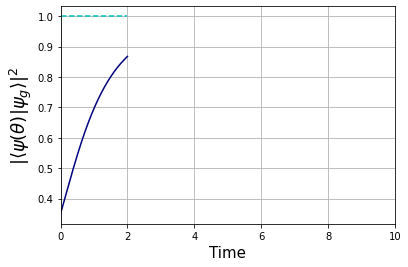

In [116]:
n = 1
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(1):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk])
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_3qutrits_exp_gate.pdf")

No handles with labels found to put in legend.


(0.0, 10.0)

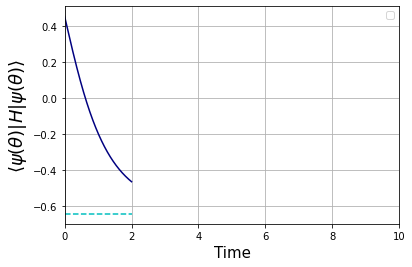

In [117]:
for kkk in range(1):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk])
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_exp_gate.pdf")

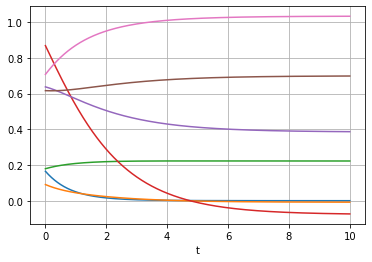

In [40]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [43]:
for i in range(coeff*N):
    print(Y[-1][i])

4.838222842295315e-06
-0.00822376007702962
0.22224045415837237
-0.07402449858619298
0.3864191038973874
0.6980257068843853
1.0326600859094566


In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

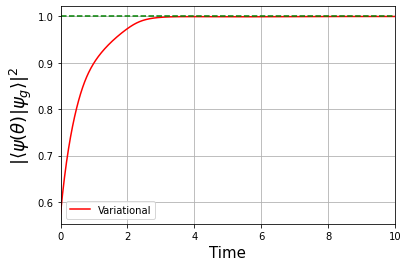

(0.0, 10.0)

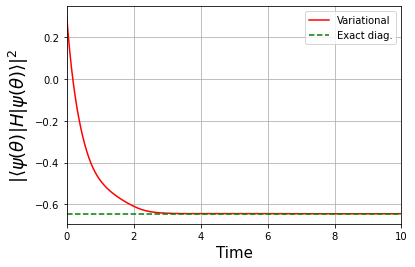

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
